In [1]:
import networkx as nx
import numpy as np
from scipy.spatial import distance
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib notebook

# Assignment 2: Belief Propagation for random matching problem

 Matching is another classical problem of graph theory. It is related to a dimer problem in statistical physics. Given a  (unweighted,
  undirected) graph $G(V,E)$ a matching $M \subseteq E$ is defined as a subset of edges such that if $(ij) \in M$ then
    no other edge that contains node $i$ or $j$ can be in $M$. In other words a matching is a subset of edges such that no two edges of the
    set share a node. 

 Fill up this _jupyter_ notebook with the skeleton of a code to solve this assignment. 

### Point a)
Write a probability distribution that is uniform over all
    matchings on a given graph. _Hint_: consider binary random variables $\sigma_{ij}$ on the network edges.

Let $\sigma_{ij} = \begin{cases}
1 \text{ , if } (ij) \in M\\
0 \text{ , else}
\end{cases}
$

Considering a node $i \in V$, at most one of the adjacent edges $(ij)\in E$ can be in the matching, i.e. $\sigma_{ij} = 1$. We define $adj(i) := \{j\in V \mid (ij) \in E\}$. Then:

$$
\begin{align}
    \sum_{j \in adj(i)} \sigma_{ij} = 1 \quad \text{ or } \quad \sum_{j \in adj(i)} \sigma_{ij} = 0
\end{align}
$$

Therefore, for a valid matching, it holds:
$$
\begin{align}
    \forall i \in V \text{ with } adj(i) \neq \emptyset: \sum_{j \in adj(i)}\sigma_{ij} \leq 1
\end{align}

\begin{align}
    \Rightarrow & \prod_{i \in V: adj(i) \neq \emptyset} \mathbb{1}_{(\sum_{j \in adj(i)}\sigma_{ij} \leq 1)} = 
    \begin{cases}
    1 \text{, if M is a valid matching}\\
    0 \text{, else}
    \end{cases}
\end{align}
$$

Multiplication with a normalization factor $\frac{1}{Z}$ results in a uniform distribution over all matchings on the graph $G$:
$$
\begin{align}
P(M) = \frac{1}{Z} \prod_{i \in V: adj(i) \neq \emptyset} \mathbb{1}_{(\sum_{j \in adj(i)}\sigma_{ij} \leq 1)}
\end{align}
$$

### Point b)
Write a probability distribution that that gives a larger weight to larger matchings, where the
    size of a matching is simply $|M|$. _Hint_: you need to write $|M|$ as a function of $|E|$ and $\sum_{(ij)\in E}\sigma_{ij}$ for $\sigma_{ij}\in M$.

Size of a matching $M$:

$$\vert M\vert = \sum_{(ij) \in E} \sigma_{ij}$$

To weight the probability, we can multiply the result from exercise $a)$ with $\vert M\vert$. 
We need a different normalization factor to ensure that it is still a probability distribution:

$$
\begin{align}
P(M) &= \frac{\vert M \vert}{Z_{b}} \prod_{i \in V: adj(i) \neq \emptyset} \mathbb{1}_{(\sum_{j \in adj(i)}\sigma_{ij} \leq 1)} \\
&= \frac{\sum_{(ij) \in E} \sigma_{ij}}{Z_{b}} \prod_{i \in V: adj(i) \neq \emptyset} \mathbb{1}_{(\sum_{j \in adj(i)}\sigma_{ij} \leq 1)}
\end{align}
$$


### Point c)
Draw a factor graph corresponding to it for the example of a graph with 6 nodes and edges $E=\left\{(1,2),(1,3),(2,3),(1,4),(2,5), (3,6)\right\}$. You can add it to the notebook as a figure or using latex package _tikz_.

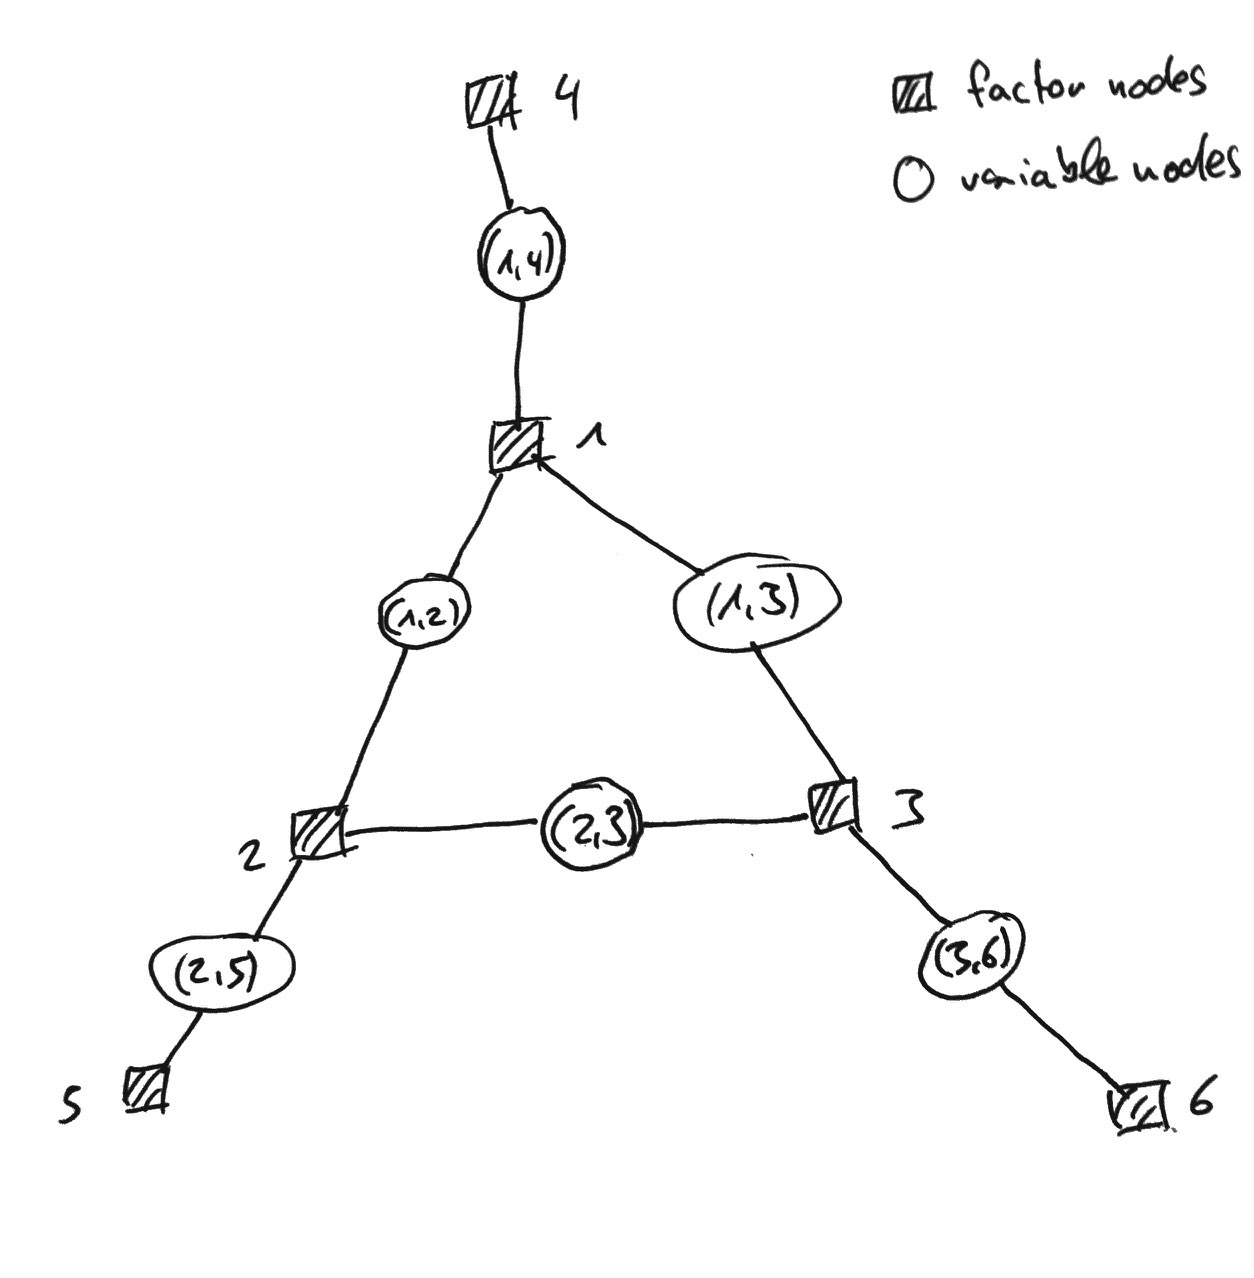

In [2]:
Image("./2c_factor_graph.png")

### Point d)
Using BP to model marginals of the matching assignment, denote as:
 * $\nu_{\sigma_{ij}}^{(ij) \to i} $ the messages from _variable_ node $(ij)$ to _function_ node $i$.
 * $  \hat{\nu}_{\sigma_{ij}}^{i \to (ij)}$ the message from _function_ node $i$ to  _variable_ node $(ij)$.  
 
Note that they are both functions of the state $\sigma_{ij}$ of variable node $(ij)$.  
	_Hint_: here variable nodes (circles) correspond to an edge $e=(i,j) \in E$ and factor nodes (squares) correspond to nodes $i \in V$ in the \textit{original} network $G(V,E)$.  
* Write BP equations for this model.   
_Hint_: write an explicit derivation for _each of the two possible_ values of $\sigma_{ij}$.
	Notice that we are implementing _hard_ constraints. This means that for each value of $\sigma_{ij}$, there can be only a limited number of _allowed_ configurations of $\left\{\sigma_{ik}\right\}$, for $k \in \partial i \setminus j$. In principle there should be $\sim 2^{k_{i}-1}$ of them, but in practice, many are not allowed once $\sigma_{ij}$ is fixed; we remain with ${k_{i}}$ allowed configurations (for one of the two values of $\sigma_{ij}$) and only one configuration allowed for the other value of $\sigma_{ij}$. Do _not_ consider the configuration where $(ij) \notin M$ AND $(ik)  \notin M$, $\forall k \in \partial i \setminus j$, for a total of ${k_{i}}-1$ allowed configuration to be considered in the BP implementation.


We define
$$\overline{\sigma}_{adj(i)} = \{\sigma_{ij} \mid j \in adj(i)\}$$

$\underline{\sigma_{ij} = 1}:$

$$
\begin{align}
      \hat{\nu}_{i \to (ij)}^{(t)}(\sigma_{ij}) &= \sum_{\overline{\sigma}_{adj(i)} \setminus \sigma_{ij}} \psi_i(\overline{\sigma}_{adj(i)}) \prod_{k \in adj(i)\setminus j} \hat{\nu}_{(ik) \to i}^{(t)}(\sigma_{ik}) \\
\end{align}
$$

Here:
$$\sigma_{ij} = 1 \Rightarrow \psi_i(\overline{\sigma}_{adj(i)}) = \begin{cases}
    1 \text{ , if } \sigma_{ik} = 0\text{ , } \forall k \neq j \\
    0 \text{ , else}
\end{cases}
$$

$$
\begin{align}
    \Rightarrow \hat{\nu}_{i \to (ij)}^{(t)}(\sigma_{ij}) &= \prod_{k \in adj(i)\setminus j} \nu_{(ik) \to i}^{(t)}(0) 
    \\
    &= \prod_{k \in adj(i)\setminus j} \prod_{b \in \partial{(ik)}\setminus i } \hat{\nu}_{b \to (ik)}^{(t-1)}(0)
    \\
    &= \prod_{k \in adj(i)\setminus j}\hat{\nu}_{k \to (ik)}^{(t-1)}(0) \qquad \text{ , since } \partial{(ik)}\setminus i = \{i, k\} \setminus i = \{k\}
\end{align}
$$

$\underline{\sigma_{ij} = 0}:$

$$\Rightarrow \psi_i(\overline{\sigma}_{adj(i)})= \mathbb{1}_{(\sum_{k\in adj(i)}\sigma_{ik} \leq 1)}=\begin{cases}
    1 \text{ , if } \sum_{k \in adj(i)}\sigma_{ik} \leq 1 \\
    0 \text{ , else}
\end{cases}
$$

$$
\begin{align}
    \hat{\nu}_{i \to (ij)}^{(t)}(\sigma_{ij}) &= \sum_{\overline{\sigma}_{adj(i)} \setminus \sigma_{ij}} \psi_i(\overline{\sigma}_{adj(i)}) \prod_{k \in adj(i)\setminus j} \nu_{(ik) \to i}^{(t)}(\sigma_{ik}) 
    \\
    &= \sum_{\overline{\sigma}_{adj(i)} \setminus \sigma_{ij}} \mathbb{1}_{(\sum_{k\in adj(i)}\sigma_{ik} \leq 1)} \prod_{k \in adj(i)\setminus j} \nu_{(ik) \to i}^{(t)}(\sigma_{ik})
    \\
    &= \sum_{\overline{\sigma}_{adj(i)} \setminus \sigma_{ij}} \mathbb{1}_{(\sum_{k\in adj(i)}\sigma_{ik} \leq 1)} \prod_{k \in adj(i)\setminus j}\prod_{b \in \partial{(ik)}\setminus i } \hat{\nu}_{b \to (ik)}^{(t-1)}(\sigma_{ik})
    \\
    &= \sum_{\overline{\sigma}_{adj(i)} \setminus \sigma_{ij}} \mathbb{1}_{(\sum_{k\in adj(i)}\sigma_{ik} \leq 1)} \prod_{k \in adj(i)\setminus j} \hat{\nu}_{k \to (ik)}^{(t-1)}(\sigma_{ik})
    \\
    &= \sum_{\overline{\sigma}_{adj(i)} \setminus \sigma_{ij}} \mathbb{1}_{(\sum_{k\in adj(i)}\sigma_{ik} = 0)} \prod_{k \in adj(i)\setminus j} \hat{\nu}_{k \to (ik)}^{(t-1)}(\sigma_{ik})\\
    &\qquad + \sum_{\overline{\sigma}_{adj(i)} \setminus \sigma_{ij}} \mathbb{1}_{(\sum_{k\in adj(i)}\sigma_{ik} = 1)} \prod_{k \in adj(i)\setminus j} \hat{\nu}_{k \to (ik)}^{(t-1)}(\sigma_{ik})
    \\
    &\approx \sum_{\overline{\sigma}_{adj(i)} \setminus \sigma_{ij}} \mathbb{1}_{(\sum_{k\in adj(i)}\sigma_{ik} = 1)} \prod_{k \in adj(i)\setminus j} \hat{\nu}_{k \to (ik)}^{(t-1)}(\sigma_{ik}) 
    \\
    &= \sum_{\overline{\sigma}_{adj(i)} \setminus \sigma_{ij} \\ \sum_{l \in adj(i)}\sigma_{il}=1} \prod_{k \in adj(i)\setminus j} \hat{\nu}_{k \to (ik)}^{(t-1)}(\sigma_{ik}) 
\end{align}
$$

### Point e)
Write the equation for the one-point marginal $P(\sigma_{i})$ and the two-point marginal $P(\sigma_{i},\sigma_{j})$ obtained from BP.

From the lecture we get:
$$
\begin{align}
    P(\sigma_{ij}) &= \prod_{k \in \partial(ij)}\hat{\nu}_{k \to (ij)}^{(t-1)}(\sigma_{ij})
    \\
    &= \hat{\nu}_{i \to (ij)}^{(t-1)}(\sigma_{ij})\hat{\nu}_{j \to (ij)}^{(t-1)}(\sigma_{ij})
\end{align}
$$

For the two-point marginals, we only consider edges $(ij),(ik)$ that share one node:

$$
\begin{align}
    F_R &= \{i\} 
    \\
    V_R &= \{(il) \mid l \in V, (il) \in E\}
    \\
    \partial{R} &= adj(i)
    \\
    P(\overline{\sigma}_{adj(i)}) &= \frac{1}{Z_R}\prod_{a \in F_R} \psi_a(x_{\partial(a)} \prod_{b\in \partial{R}}\hat{\nu}^*_{b \to i(b)}(x_{i(b)})
    \\
    &= \frac{1}{Z_R} \psi_i(\overline{\sigma}_{adj(i)}) \prod_{k \in adj(i)} \hat{\nu}^*_{k \to (ik)}(\sigma_{ik})
    \\
    &= \frac{1}{Z_R} \mathbb{1}_{(\sum_{k \in adj(i)} \sigma_{ik} \leq 1)} \prod_{k \in adj(i)} \hat{\nu}^*_{k \to (ik)}(\sigma_{ik})
    \\
    P(\sigma_{ij}, \sigma_{ik}) &= \sum_{\overline{\sigma}_{adj(i)}\setminus\{\sigma_{ij}, \sigma_{ik}\}} P(\overline{\sigma}_{adj(i)})
\end{align}
$$

## BP Implementation (point f)

### Point i)
Implement the BP equations for Erdos-Renyi graphs of $N=200$ nodes as derived above. 

In [3]:
# Generate graph
N, c = 200, 4  # N is the number of nodes, c is the average degree
G = nx.erdos_renyi_graph(n=N, p=c/(N-1), seed=29)
G = G.to_directed()

In [4]:
# Checking the convergence
def convergence(messages, G, abs_tol):
    err = 0.0
    
    for e in messages:
        err += np.sum(np.abs(messages[e] - G.edges()[e]['message_t']))
        
    err /= G.number_of_edges()
    
    return(err, err < abs_tol)

In [5]:
def BP(G, init='random', update='random', max_it=1000, abs_tol=1e-4, alpha=0.1, report=False, seed=98):
    
    if init == 'random':
        np.random.seed(seed)
        for e in G.edges():
            G.edges()[e]['message_t'] = np.random.dirichlet([1, 1])#(low=0, high=1, size=2)
            G.edges()[e]['message_t'] = G.edges()[e]['message_t'] / np.sum(G.edges()[e]['message_t'])
    elif init == 'all-negative':
        for e in G.edges():
            G.edges()[e]['message_t'] = np.zeros(2, dtype=np.float)
            G.edges()[e]['message_t'][0] = 1 - alpha
            G.edges()[e]['message_t'][1] = alpha
    elif init == 'all-positive':
        for e in G.edges():
            G.edges()[e]['message_t'] = np.zeros(2, dtype=np.float)
            G.edges()[e]['message_t'][0] = alpha
            G.edges()[e]['message_t'][1] = 1 - alpha
        
    # Iterating
    conv, it = False, 0
    differences = []
    
    if update=='parallel':
        while not conv and it<max_it:
            message_new = {}
            for e in G.edges():
                sender = e[0]
                receiver = e[1]
                
                # sigma_ij = 1
                message_sig_1 = 1.0
                
                if len(list(G.neighbors(sender))) <= 1:
                    continue
                    
                for k in G.neighbors(sender):
                    if k == receiver:
                        continue
                    message_sig_1 *= G.edges()[(k, sender)]['message_t'][0]
                
                # sigma_ij = 0
                message_sig_0 = 0.0
                
                for l in G.neighbors(sender):
                    if l == receiver:
                        continue
                    
                    prod = G.edges()[(l, sender)]['message_t'][1]
                    
                    for k in G.neighbors(sender):
                        if (k == receiver) or (k == l):
                            continue
                        prod *= G.edges()[(k, sender)]['message_t'][0]
                    
                    message_sig_0 += prod
                 
                m_new = np.array([message_sig_0, message_sig_1], dtype=np.float) 
                message_new[e] = m_new / np.sum(m_new)
                 
            diff, conv = convergence(message_new, G, abs_tol)
            differences.append(diff)
            it+=1

            for e in G.edges():
                try:
                    G.edges()[e]['message_t'] = message_new[e]
                except:
                    pass
                
    elif update=='random':
        while not conv and it<max_it:
            message_old = {}
            perm = list(G.edges())
            np.random.seed(seed)
            np.random.shuffle(perm)
            for e in perm:
                message_old[e] = G.edges()[e]['message_t']
                sender = e[0]
                receiver = e[1]
                
                # sigma_ij = 1
                message_sig_1 = 1.0
                
                if len(list(G.neighbors(sender))) <= 1:
                    continue
                
                for k in G.neighbors(sender):
                    if k == receiver:
                        continue
                    message_sig_1 *= G.edges()[(k, sender)]['message_t'][0]
                
                # sigma_ij = 0
                message_sig_0 = 0.0
                
                for l in G.neighbors(sender):
                    if l == receiver:
                        continue
                    prod = G.edges()[(l, sender)]['message_t'][1]
                    
                    for k in G.neighbors(sender):
                        if k == receiver or k == l:
                            continue
                        prod *= G.edges()[(k, sender)]['message_t'][0]
                    
                    message_sig_0 += prod
                
                m_new = np.array([message_sig_0, message_sig_1], dtype=np.float)
                G.edges()[e]['message_t'] = m_new / np.sum(m_new)

            diff, conv = convergence(message_old, G, abs_tol)
            differences.append(diff)
            it+=1
            seed+=1
    
    if report:
        print('Number of iterations: {0}'.format(it))
    
    return(it, differences)

## Point ii) 
Check how the behavior depends on the order of update for the ``random'' initialization, i.e. compare what happens if you update all messages at once or sequentially at random one by one.

Number of iterations: 525
Number of iterations: 16


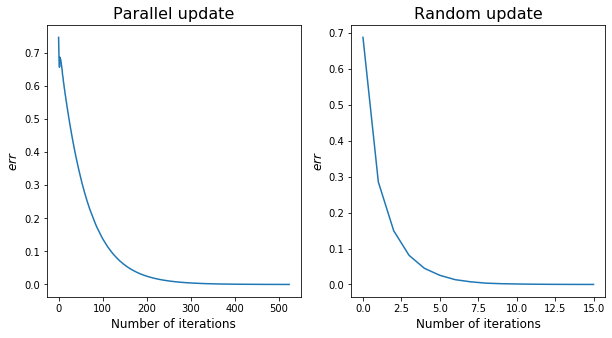

In [6]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

# Parallel update (all messages at once)
x, y = BP(G, update='parallel', report=True)
ax[0].plot(np.arange(x), y)
ax[0].set_title('Parallel update', size=16)
ax[0].set_xlabel('Number of iterations',size=12)
ax[0].set_ylabel('$err$',size=12)

# Random update (one by one)
x, y = BP(G, update='random', report=True)
ax[1].plot(np.arange(x), y)
ax[1].set_title('Random update', size=16)
ax[1].set_xlabel('Number of iterations', size=12)
ax[1].set_ylabel('$err$',size=12)

plt.show()

As last time, the parallel update needs more iterations for reaching the converge than the random update. 

### Point iii)
  Initialize BP in 3 different ways (recall that they are a function of random variables $\sigma_{ij} \in \left\{0,1\right\}$): 
* ``random'' : each of the two possible values of $\sigma_{ij}$ is selected uniformly at random in $(0,1)$;
*  ``all-negative'' : close to the point $(1,0)$;
* ``all-positive'' : close to the point $(0,1)$;  

and iterate the equations until convergence for each of these three.   
Define converge as the time when the $err< \tilde{\epsilon}$ (as defined in tutorial 10).  
* Plot the behavior of  $err$ as a function of iteration time for the 3 different initializations (one plot with 3 curves).  

Use the update (parallel or sequential at random) that converges faster.



Initialization random

Initialization all-negative

Initialization all-positive


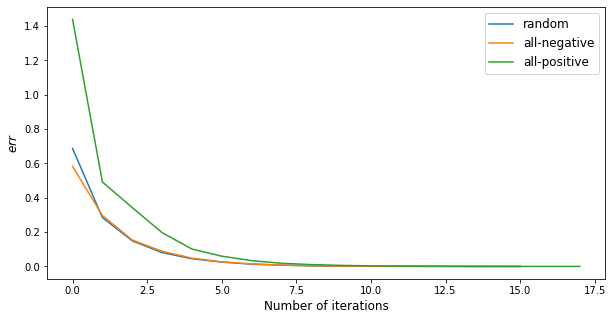

In [7]:
N, c = 200, 4

G = nx.erdos_renyi_graph(n=N, p=c/(N-1), seed=29)
G = G.to_directed()

plt.figure(figsize=(10,5))
for init in ['random', 'all-negative', 'all-positive']:
    print('\nInitialization {0}'.format(init))
    x, y = BP(G, update='random', init=init)
    plt.plot(np.arange(x), y, label=init)
plt.legend(fontsize=12)
plt.xlabel('Number of iterations',size=12)
plt.ylabel('$err$', size=12)
plt.show()

### Point iv)
For parameters where the update converges, plot the convergence time as a function of the average degree $c=[2,\dots,7]$.  
Do this on as large graphs as is  feasible with your code.

In [8]:
c_choices = np.linspace(2, 7, 12)
N_choices = [50, 100, 200]
result = np.zeros((len(c_choices),len(N_choices)+1))
result[:, 0] = c_choices
seed_graph = 29
for j, N in enumerate(N_choices):
    print(N)
    for i, c in enumerate(c_choices):
        iterations = []
        for _ in range(5):
            G = nx.erdos_renyi_graph(n=N, p=c/(N-1), seed=seed_graph)
            G = G.to_directed()        
            x, y = BP(G, update='random', init='all-negative')
            iterations.append(x)
            seed_graph+=1
        result[i, j+1] = np.median(iterations)

50
100
200


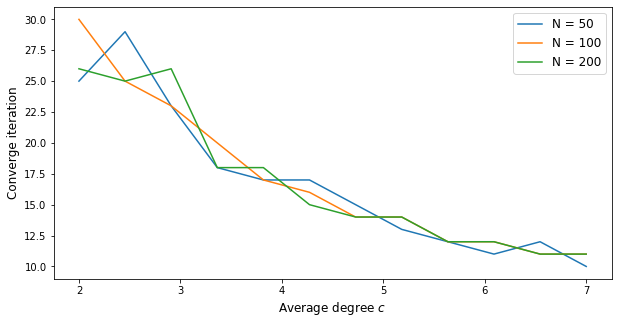

In [9]:
plt.figure(figsize=(10,5))
for col in range(len(N_choices)):
    plt.plot(result[:,0], result[:,col+1], label='N = {0}'.format(N_choices[col]))
plt.legend(fontsize=12)
plt.xlabel('Average degree $c$', size=12)
plt.ylabel('Converge iteration', size=12)
plt.show()

### Point v)
Assign one color value $\in \left\{0,1\right\}$, $1$ if the edge belong to the matching, 0 otherwise, to each edge at convergence, based on the argmax of the suitable marginals.  

In [10]:
# Attaching marginal distributions to each edge
def marginals_one_point(G):
    for e in G.edges():
        i = e[0]
        j = e[1]

        prod = 1
        prod *= G.edges()[(i,j)]['message_t']
        prod *= G.edges()[(j,i)]['message_t']

        G.edges()[(i,j)]['marginal'] = prod
        
# Assessing the matching
def accuracy(G):
    # error is when a violation occurs 
    # returns the number of violations (not a fraction)
    errors = 0
    for i in G.nodes():
        
        if len(list(G.neighbors(i))) <= 1:
            continue
        
        sigma_sum = 0
        for k in G.neighbors(i):
            sigma_sum += np.argmax(G.edges()[k, i]['marginal'])
            
        if sigma_sum > 1:
            errors += 1
    return(errors/2)

def calculate_edge_in_matching(G):
    '''
    Fraction of edges in M
    '''
    count_M = 0
    for e in G.edges():
        if np.argmax(G.edges()[e]['marginal']) == 1:
            count_M += 1
            
    return count_M / G.number_of_edges()

Compute the fraction of violations of the matching requirement you get over $N_{real}=10$ initializations of the graph and plot them as a function of $c$.


In [11]:
c_choices = np.linspace(2, 7, 6)
result1 = np.zeros((len(c_choices),4))
result1[:, 0] = c_choices
N = 100
seed = 29
N_real=10
for i, c in enumerate(c_choices):
    errors = []
    n_one = 0
    for _ in range(N_real):
        G = nx.erdos_renyi_graph(n=N, p=c/(N-1), seed=seed)
        G = G.to_directed()
        x, y = BP(G, update='random', init='all-negative')
        marginals_one_point(G)
        errors.append(accuracy(G) / G.number_of_edges())  
        M_size= calculate_edge_in_matching(G)
        n_one+=M_size
        seed+=1
        print(c,errors[-1],M_size)
    print()
    result1[i, 1] = np.mean(errors)
    result1[i, 2] = np.std(errors)
    result1[i, 3] = n_one/float(N_real)  # save the mean of the fraction of +1 
    print('Total:',c,result1[i, 1],result1[i, 3])
    print()
    print()

2.0 0.0 0.27522935779816515
2.0 0.0 0.24770642201834864
2.0 0.0 0.29347826086956524
2.0 0.0 0.21052631578947367
2.0 0.0 0.27184466019417475
2.0 0.0 0.2608695652173913
2.0 0.0 0.2545454545454545
2.0 0.0 0.2396694214876033
2.0 0.0 0.2808988764044944
2.0 0.0 0.2702702702702703

Total: 2.0 0.0 0.26050386045949414


3.0 0.0 0.10778443113772455
3.0 0.0 0.1503267973856209
3.0 0.0 0.16666666666666666
3.0 0.0 0.2246376811594203
3.0 0.0 0.21428571428571427
3.0 0.0 0.18292682926829268
3.0 0.0 0.19424460431654678
3.0 0.0 0.24615384615384617
3.0 0.0 0.15172413793103448
3.0 0.0 0.2578125

Total: 3.0 0.0 0.1896563208304867


4.0 0.0 0.06372549019607843
4.0 0.0 0.12562814070351758
4.0 0.0 0.09268292682926829
4.0 0.0 0.17412935323383086
4.0 0.0 0.19473684210526315
4.0 0.0 0.1164021164021164
4.0 0.0 0.116751269035533
4.0 0.0 0.13043478260869565
4.0 0.0 0.0947867298578199
4.0 0.0 0.16091954022988506

Total: 4.0 0.0 0.12701971912020085


5.0 0.0 0.04329004329004329
5.0 0.0 0.06324110671936758
5.0 0.0 0.06

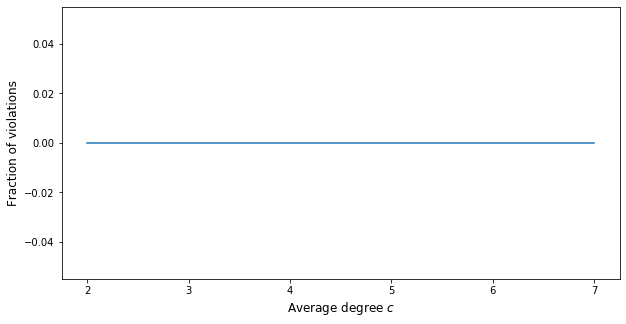

In [12]:
plt.figure(figsize=(10,5))
plt.plot(result1[:,0], result1[:,1])
plt.xlabel('Average degree $c$', size=12)
plt.ylabel('Fraction of violations', size=12)
plt.show()

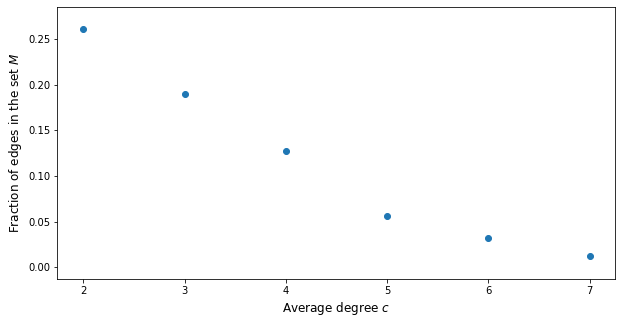

In [13]:
plt.figure(figsize=(10,5))
plt.scatter(result1[:,0], result1[:,3])
plt.xlabel('Average degree $c$', size=12)
plt.ylabel('Fraction of edges in the set $M$', size=12)
plt.show()

### Additional examples

In [14]:
def draw_graph(G, init):
    plt.figure(figsize=(10,5))
    # nodes
    pos = nx.spring_layout(G)
    nx.draw_networkx_nodes(G, pos, nodelist=list(np.arange(N)), node_size=500, node_color='lightblue')
    # some math labels
    labels = {}
    for n in range(N):
        labels[n] = n
    nx.draw_networkx_labels(G, pos, labels, font_size=12)

    # edges
    col_positive = []
    col_negative = []
    for e in G.edges():
        if np.argmax(G.edges()[e]['marginal'])==1:
            col_positive.append(e)
        else:
            col_negative.append(e)

    nx.draw_networkx_edges(G, pos, edgelist=col_negative, width=1, edge_color='b')
    nx.draw_networkx_edges(G, pos, edgelist=col_positive,width=2, edge_color='r')
    
    plt.title('Initialization: {0}'.format(init), size=15)
    plt.show()

Number of errors:  0.0


/Applications/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Applications/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


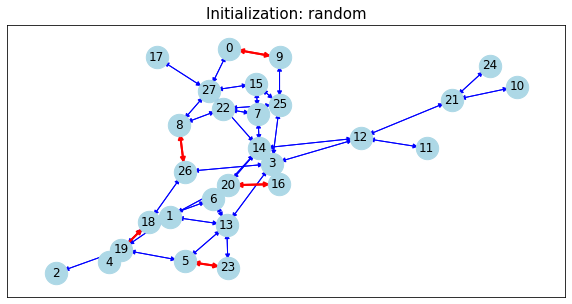

Number of errors:  0.0


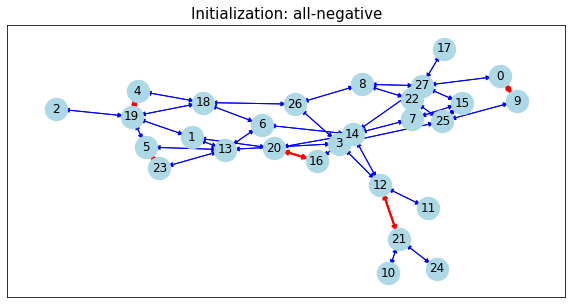

Number of errors:  0.0


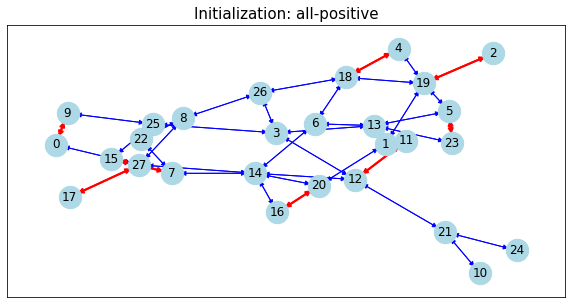

In [15]:
N, c = 28, 3
G = nx.erdos_renyi_graph(n=N, p=c/(N-1), seed=486)
G = G.to_directed()
for init in ['random', 'all-negative', 'all-positive']:
    x, y = BP(G, update='random', init=init)
    marginals_one_point(G)
    print('Number of errors: ', accuracy(G))
    draw_graph(G, init)

### Point vi)
Plot also the fraction of edges in the set $M$ as a function of $c$ and for the 3 different initializations on the same plot. 

In [16]:
# Generate graph
N, c = 100, 3  # N is the number of nodes, c is the average degree
G = nx.erdos_renyi_graph(n=N, p=c/(N-1), seed=29)
G = G.to_directed()

N_real=10

In [21]:
initializations=['random', 'all-negative', 'all-positive']
degrees=[2,3,4,5,6,7]

M={};errors={}
for init in initializations:
    errors[init]={}
    M[init]={}
    for c in degrees:
        errors[init][c]=np.zeros(N_real)
        M[init][c]=np.zeros(N_real)

for c in degrees:
    for r in range(N_real):
        G = nx.erdos_renyi_graph(n=N, p=c/(N-1),seed=r)
        G = G.to_directed()
        for init in initializations:
            x, y = BP(G, update='random', init=init)
            marginals_one_point(G)
            errors[init][c][r]=accuracy(G)/N  # the maximum number of errors is given by the number of nodes
            M[init][c][r]=calculate_edge_in_matching(G)

Text(0.5, 0, 'c')

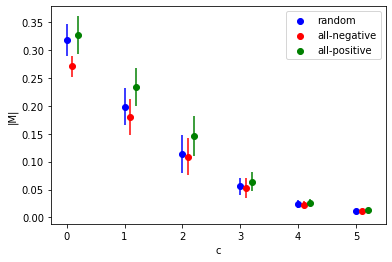

In [22]:
colors={'random':'b','all-negative':'r','all-positive':'g'}
plt.figure()

t=0
for c in degrees:
    i=t
    for init in initializations:
        if t==0:
            plt.scatter(i,M[init][c].mean(),label=init,c=colors[init])
        else:
            plt.scatter(i,M[init][c].mean(),c=colors[init])
        plt.errorbar(i,M[init][c].mean(), yerr=M[init][c].std(),c=colors[init])
        i+=0.1
    t+=1

plt.legend(loc='best')
plt.ylabel('|M|')
plt.xlabel('c')
# plt.xticks([])

### Point vii) 
Comment on how the behavior depends on the initialization.

The "all-positive" initialization shows noticeably worse results than the other two.

A likely reason for this is the fact that the algorithm starts in a state that is as far

as possible from a valid matching. While the "random" initialization might lead to a valid 

matching as starting point, the "all-negative" initialization gives always a valid matching

from the beginning. This also explains the slightly higher better starting point of "all-negative"

in relation "random" (regarding the err plot)